In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("cleaned_freakshow_training.csv")


In [3]:
# 创建一个函数，用于标准化 Category 列
def clean_category(category):
    category = category.strip().lower()  # 去除首尾空格并统一小写

    # 修正特定类别拼写和大小写不一致
    corrections = {
        "car": "car show",
        "car show": "car show",
        "car show*": "car show",
        "carshow": "car show",
        "politics": "politics",
        "mass media": "mass media",
        "sports": "sports",
        "music": "music",
        "freakshow": "freakshow",
        "sideshow": "sideshow",
        "sideshow*": "sideshow",
        "wine": "wine",
        "theater": "theatre",  # 修正美式拼写
        "theatre": "theatre",
        "graphic design": "graphic design",
        "crime": "crime",
        "tech": "tech",
        "economy": "economy",
        "celebrity": "celebrity",
        "drunkeness": "drunkeness",
        "antiques": "antiques"
    }

    # 返回修正后的类别
    return corrections.get(category, category)  # 如果未匹配到 corrections，则保留原类别

# 应用清理函数到 Category 列
data['Category'] = data['Category'].apply(clean_category)

# 检查清理后的类别分布
print(data['Category'].value_counts())


sideshow          213
politics          193
sports            145
music             109
mass media         87
car show           69
theatre            29
art                19
freakshow          13
economy            11
crime               7
tech                3
wine                3
celebrity           2
graphic design      2
antiques            1
drunkeness          1
halloween           1
Name: Category, dtype: int64


In [19]:

category_counts = data['Category'].value_counts()
categories_to_remove = category_counts[category_counts < 10].index.tolist()


data = data[~data['Category'].isin(categories_to_remove)].reset_index(drop=True)

print("Filtered category distribution:")
print(data['Category'].value_counts())

print(f"Original data size: {len(data)}, Filtered data size: {len(data)}")


Filtered category distribution:
sideshow      201
politics      183
sports        133
music         104
mass media     83
car show       66
theatre        28
art            17
freakshow      12
economy        10
Name: Category, dtype: int64
Original data size: 837, Filtered data size: 837


In [20]:
len(data)

837

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         908 non-null    object
 1   Date             853 non-null    object
 2   URL              908 non-null    object
 3   Content          856 non-null    object
 4   content_length   908 non-null    int64 
 5   cleaned_content  856 non-null    object
 6   label_encoded    908 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 49.8+ KB


In [22]:
# unique encoding
category_to_label = {category: idx for idx, category in enumerate(sorted(data['Category'].unique()))}

data['label_encoded'] = data['Category'].map(category_to_label)

print("Mapping from Category to label_encoded:")
print(category_to_label)

print("\nEncoded label distribution:")
print(data['label_encoded'].value_counts())


Mapping from Category to label_encoded:
{'art': 0, 'car show': 1, 'economy': 2, 'freakshow': 3, 'mass media': 4, 'music': 5, 'politics': 6, 'sideshow': 7, 'sports': 8, 'theatre': 9}

Encoded label distribution:
7    201
6    183
8    133
5    104
4     83
1     66
9     28
0     17
3     12
2     10
Name: label_encoded, dtype: int64


In [24]:
data.to_csv("cleaned_data.csv")

In [25]:
# check cleaned_content ,label_encoded miss value
missing_cleaned_content = data['cleaned_content'].isnull().sum()
missing_label_encoded = data['label_encoded'].isnull().sum()

print(f"'cleaned_content' miss value：{missing_cleaned_content}")
print(f"'label_encoded' miss value：{missing_label_encoded}")


'cleaned_content' miss value：0
'label_encoded' miss value：0


In [26]:
data = data.dropna(subset=['cleaned_content']).reset_index(drop=True)
print(len(data))

837


count    8.370000e+02
mean     5.200495e+03
std      5.926315e+04
min      5.000000e+00
25%      1.047000e+03
50%      2.157000e+03
75%      3.543000e+03
max      1.708178e+06
Name: content_length, dtype: float64


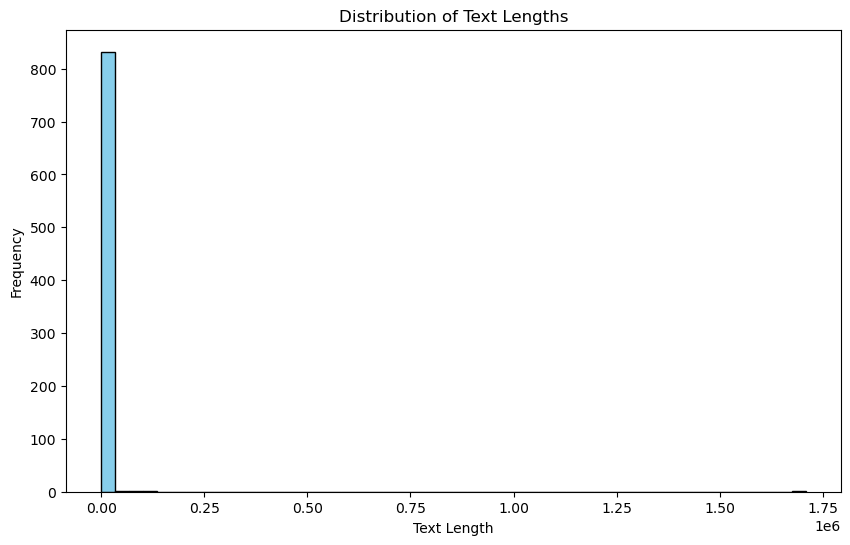

In [27]:
import matplotlib.pyplot as plt

data['content_length'] = data['cleaned_content'].apply(len)

print(data['content_length'].describe())

# length distribution
plt.figure(figsize=(10, 6))
plt.hist(data['content_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [28]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define a function to tokenize text data with truncation and padding
def tokenize_data(texts, tokenizer, max_length=512):
    """
    Tokenize input text data using BERT tokenizer.
    Parameters:
        texts (list of str): List of text data to tokenize.
        tokenizer (BertTokenizer): Pre-trained BERT tokenizer.
        max_length (int): Maximum sequence length for padding/truncation.
    Returns:
        dict: Dictionary with tokenized input_ids, attention_mask.
    """
    return tokenizer(
        texts,
        truncation=True,         # Truncate sequences to max_length
        padding="max_length",    # Pad sequences to max_length
        max_length=max_length,   # Maximum sequence length
        return_tensors="pt"      # Return PyTorch tensors
    )

# Tokenize the text data (cleaned_content column)
max_length = 512  # Define the fixed sequence length
encodings = tokenize_data(data['cleaned_content'].tolist(), tokenizer, max_length=max_length)

# Check the shape of tokenized inputs
print(f"Shape of input_ids: {encodings['input_ids'].shape}")        # Shape of token IDs
print(f"Shape of attention_mask: {encodings['attention_mask'].shape}")  # Shape of attention mask


Shape of input_ids: torch.Size([837, 512])
Shape of attention_mask: torch.Size([837, 512])


In [29]:
import torch
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    """
    Custom PyTorch Dataset for text classification.
    This class combines tokenized inputs and labels.
    """
    def __init__(self, encodings, labels):
        """
        Initialize the dataset with tokenized inputs and labels.
        Parameters:
            encodings (dict): Tokenized input data (input_ids and attention_mask).
            labels (list or torch.Tensor): Corresponding labels for the data.
        """
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        Parameters:
            idx (int): Index of the sample to retrieve.
        Returns:
            dict: A dictionary containing input_ids, attention_mask, and labels.
        """
        item = {key: val[idx] for key, val in self.encodings.items()}  # input_ids and attention_mask
        item['labels'] = self.labels[idx]  # Add the label
        return item

# Prepare labels
labels = data['label_encoded'].tolist()  # Extract labels as a list

# Create dataset instance
dataset = TextClassificationDataset(encodings, labels)

# Check the dataset
print(f"Number of samples in the dataset: {len(dataset)}")
print("Example of a dataset sample:")
print(dataset[0])  # Display the first sample


Number of samples in the dataset: 837
Example of a dataset sample:
{'input_ids': tensor([  101, 22042,  3696,  5993,  2744,  4650,  3191,  9394,  3343,  3696,
         1999,  6279,  2591,  4070,  2180,  2102,  2695,  4070, 20786,  2442,
         2421,  3696,  1999,  6279,  2591,  4070,  2180,  2102,  2695,  4070,
        20786,  2442,  2421,  2064,  2102,  2767,  2208,  5045,  2067, 28997,
         4971,  2047,  2299, 20739,  2491,  2028,  2154,  4971,  3333,  4487,
         2015,  2650,  6136,  2402,  5003,  1051,  9541,  2226,  2226,  2226,
         6160,  2225,  7110,  2102,  2166, 11623,  2994, 12065,  2102,  2175,
         2078,  2707,  2514,  2066,  3190,  2562,  4172,  2072, 19808,  3501,
         3903, 14406,  2208,  9680, 20739,  2491,  2207,  9857,  2244, 18592,
         3128,  4431,  4971, 11155, 13552,  7867, 15969,  4679,  7867,  6884,
         5745, 15994,  9680,  4691,  5598, 15969,  4679,  2123,  2102, 15121,
         2051,  2175,  2852, 10993,  9096,  2123,  2102,  968

In [30]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset into training and validation sets
train_size = 0.8  # Proportion of data used for training
train_indices, val_indices = train_test_split(
    list(range(len(dataset))), 
    test_size=1 - train_size, 
    random_state=42
)

# Subset the dataset for training and validation
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Define DataLoaders for training and validation
batch_size = 16  # Define batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check the size of each set
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples: 669
Number of validation samples: 168


In [31]:
from transformers import BertForSequenceClassification

# Define the number of classes (unique labels in the dataset)
num_labels = len(data['label_encoded'].unique())+1
print("num_labels are", num_labels)
# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",    # Pre-trained BERT model
    num_labels=num_labels   # Number of output classes
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded and moved to device: {device}")


num_labels are 11


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device: cpu


In [32]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define loss function (for classification tasks)
loss_fn = CrossEntropyLoss()

# Optionally, define a learning rate scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Decays learning rate every 2 epochs

print("Optimizer, loss function, and scheduler initialized.")


Optimizer, loss function, and scheduler initialized.


/Users/a123/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
from tqdm import tqdm
import torch

# Define the training loop
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    """
    Train the model for one epoch.
    Parameters:
        model (torch.nn.Module): BERT model with classification head.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (function): Loss function (e.g., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizer (e.g., AdamW).
        device (torch.device): Device to run the training on (CPU or GPU).
    Returns:
        float: Average loss over the epoch.
    """
    model.train()  # Set model to training mode
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()  # Clear gradients from the previous step

        # Move batch data to the target device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Return average loss
    return total_loss / len(data_loader)


# Define the validation loop
def eval_model(model, data_loader, loss_fn, device):
    """
    Evaluate the model on the validation set.
    Parameters:
        model (torch.nn.Module): BERT model with classification head.
        data_loader (DataLoader): DataLoader for validation data.
        loss_fn (function): Loss function (e.g., CrossEntropyLoss).
        device (torch.device): Device to run the evaluation on (CPU or GPU).
    Returns:
        tuple: (average loss, accuracy)
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch data to the target device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


In [36]:
# Define the number of training epochs
num_epochs = 7  # You can adjust based on your dataset and task

# Track training progress
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

# Main training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)

    # Train the model for one epoch
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Training loss: {train_loss:.4f}")

    # Evaluate the model on the validation set
    val_loss, val_accuracy = eval_model(model, val_loader, loss_fn, device)
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")

    # Save metrics for plotting or analysis
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)

    # Update learning rate (if using a scheduler)
    if scheduler:
        scheduler.step()

# Print summary of training
print("\nTraining complete!")
print(f"Best validation accuracy: {max(history['val_accuracy']):.4f}")



Epoch 1/10
------------------------------


Training: 100%|██████████| 42/42 [12:57<00:00, 18.51s/it]


Training loss: 2.0545


Evaluating: 100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


Validation loss: 1.7221
Validation accuracy: 0.4940

Epoch 2/10
------------------------------


Training:   2%|▏         | 1/42 [00:16<11:19, 16.58s/it]

In [ ]:
# Split off a test set if not already done
from sklearn.model_selection import train_test_split

_, test_indices = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=42)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")


Number of test samples: 257


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a given dataset.
    Parameters:
        model (torch.nn.Module): Trained model to evaluate.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to perform evaluation on.
    Returns:
        dict: Evaluation metrics including accuracy and classification report.
    """
    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []

    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            # Move batch data to the target device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Store predictions and true labels
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, output_dict=True)

    return {"accuracy": accuracy, "classification_report": report}


In [28]:
# Evaluate the model on the test set
results = evaluate_model(model, test_loader, device)

# Print accuracy
print(f"Test Accuracy: {results['accuracy']:.4f}")

# Print classification report
from pprint import pprint
print("\nClassification Report:")
pprint(results['classification_report'])


Test Accuracy: 0.7899

Classification Report:
{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 6},
 '10': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 1},
 '12': {'f1-score': 0.8181818181818182,
        'precision': 0.84375,
        'recall': 0.7941176470588235,
        'support': 34},
 '13': {'f1-score': 0.8571428571428572,
        'precision': 0.8888888888888888,
        'recall': 0.8275862068965517,
        'support': 29},
 '14': {'f1-score': 0.8695652173913043,
        'precision': 0.8163265306122449,
        'recall': 0.9302325581395349,
        'support': 43},
 '15': {'f1-score': 0.802721088435374,
        'precision': 0.7195121951219512,
        'recall': 0.9076923076923077,
        'support': 65},
 '17': {'f1-score': 0.9295774647887325,
        'precision': 0.8918918918918919,
        'recall': 0.9705882352941176,
        'support': 34},
 '20': {'f1-score': 0.6666666666666667,
        'precision': 0.8333333333333334,
        'recall': 0.55555

/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
